In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns  
from tqdm.notebook import tqdm # Thêm thư viện để xem thanh tiến trình


# Thiết lập để import từ thư mục src
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.features import lexical_features
from src.features import host_features # Import file mới
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Kích hoạt thanh tiến trình cho pandas
tqdm.pandas()

In [2]:
# === CELL 2 (PHIÊN BẢN CUỐI CÙNG - SỬA LỖI IMPORT) ===

PROCESSED_DATA_PATH = '../data/processed/dataset_processed.csv'
df = pd.read_csv(PROCESSED_DATA_PATH)

# --- Hàm trợ giúp để lấy đúng các hàm do chúng ta tự viết ---
def get_feature_functions(module):
    """
    Hàm này sẽ duyệt qua một module và chỉ lấy ra các hàm do người dùng định nghĩa,
    bỏ qua các module đã import và các hàm hệ thống.
    """
    functions = {}
    for name, func in module.__dict__.items():
        # Kiểm tra xem nó có phải là hàm, không phải là hàm hệ thống,
        # và được định nghĩa trong chính module đó (không phải là import)
        if callable(func) and not name.startswith("__") and func.__module__ == module.__name__:
            functions[name] = func
    return functions

# --- Trích xuất đặc trưng văn bản ---
print("Bắt đầu trích xuất đặc trưng văn bản...")
lexical_funcs = get_feature_functions(lexical_features)
for name, func in tqdm(lexical_funcs.items(), desc="Lexical Features"):
    df[name] = df['url'].apply(func)

# --- Trích xuất đặc trưng máy chủ theo từng LÔ ---
print("\nBắt đầu trích xuất đặc trưng máy chủ theo từng lô...")
host_funcs = get_feature_functions(host_features)

# Kích thước mỗi lô
batch_size = 10000

for name, func in host_funcs.items():
    print(f"\n--- Trích xuất '{name}' ---")
    
    feature_results = []
    
    for i in tqdm(range(0, len(df), batch_size), desc=f"Processing {name}"):
        batch = df['url'][i:i+batch_size]
        try:
            batch_results = batch.apply(func)
            feature_results.extend(batch_results)
        except Exception as e:
            print(f"Lỗi nghiêm trọng ở lô bắt đầu từ vị trí {i} khi trích xuất {name}: {e}")
            feature_results.extend([-1] * len(batch))

    df[name] = feature_results

print("\nTrích xuất toàn bộ đặc trưng hoàn tất!")

Bắt đầu trích xuất đặc trưng văn bản...


Lexical Features:   0%|          | 0/15 [00:00<?, ?it/s]


Bắt đầu trích xuất đặc trưng máy chủ theo từng lô...

--- Trích xuất 'has_ip_address_in_hostname' ---


Processing has_ip_address_in_hostname:   0%|          | 0/51 [00:00<?, ?it/s]


--- Trích xuất 'get_subdomain_count' ---


Processing get_subdomain_count:   0%|          | 0/51 [00:00<?, ?it/s]


--- Trích xuất 'get_domain_age_days' ---


Processing get_domain_age_days:   0%|          | 0/51 [00:00<?, ?it/s]


--- Trích xuất 'get_domain_lifespan_days' ---


Processing get_domain_lifespan_days:   0%|          | 0/51 [00:00<?, ?it/s]


Trích xuất toàn bộ đặc trưng hoàn tất!


In [3]:
FINAL_FEATURES_PATH = '../data/processed/dataset_final_features.csv'

# Lưu lại để dùng cho các lần sau
df.to_csv(FINAL_FEATURES_PATH, index=False)
print(f"Đã lưu bộ dữ liệu với đầy đủ đặc trưng tại: {FINAL_FEATURES_PATH}")

# (Tùy chọn) Bạn có thể khởi động lại kernel và chỉ chạy cell này để tải dữ liệu đã xử lý
df_final = pd.read_csv(FINAL_FEATURES_PATH)
print("\nTải lại bộ dữ liệu đầy đủ đặc trưng thành công!")
print(df_final.info())

Đã lưu bộ dữ liệu với đầy đủ đặc trưng tại: ../data/processed/dataset_final_features.csv

Tải lại bộ dữ liệu đầy đủ đặc trưng thành công!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507195 entries, 0 to 507194
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   url                         507195 non-null  object
 1   label                       507195 non-null  int64 
 2   get_url_length              507195 non-null  int64 
 3   get_hostname_length         507195 non-null  int64 
 4   count_dots                  507195 non-null  int64 
 5   count_hyphens               507195 non-null  int64 
 6   count_at_symbol             507195 non-null  int64 
 7   count_slashes               507195 non-null  int64 
 8   count_question_mark         507195 non-null  int64 
 9   count_equals                507195 non-null  int64 
 10  count_and_symbol            507195 non-null  int64 
 11  get_p


Số lượng giá trị NaN trong các cột đặc trưng:
get_url_length         0
get_hostname_length    0
count_dots             0
count_hyphens          0
count_at_symbol        0
dtype: int64

Bắt đầu huấn luyện mô hình Random Forest trên bộ đặc trưng đầy đủ...
Huấn luyện hoàn tất!

--- Đánh giá mô hình Random Forest (Hybrid Features) ---
              precision    recall  f1-score   support

  Legitimate       0.91      0.96      0.93     78579
    Phishing       0.82      0.66      0.73     22860

    accuracy                           0.89    101439
   macro avg       0.86      0.81      0.83    101439
weighted avg       0.89      0.89      0.89    101439



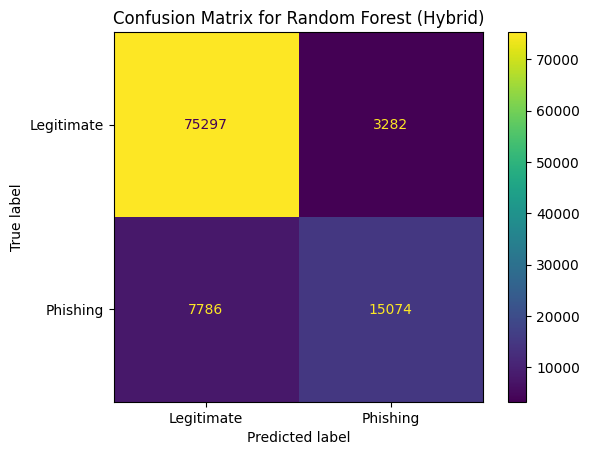

In [4]:
# Bỏ các cột không phải đặc trưng
X = df_final.drop(columns=['url', 'label'])
y = df_final['label']

# Kiểm tra xem có cột nào chứa giá trị NaN không
print("\nSố lượng giá trị NaN trong các cột đặc trưng:")
print(X.isnull().sum().sort_values(ascending=False).head())

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Huấn luyện mô hình
print("\nBắt đầu huấn luyện mô hình Random Forest trên bộ đặc trưng đầy đủ...")
model_rf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_rf_final.fit(X_train, y_train)
print("Huấn luyện hoàn tất!")

# Đánh giá
y_pred_rf_final = model_rf_final.predict(X_test)
print("\n--- Đánh giá mô hình Random Forest (Hybrid Features) ---")
print(classification_report(y_test, y_pred_rf_final, target_names=['Legitimate', 'Phishing']))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_final, display_labels=['Legitimate', 'Phishing'])
plt.title("Confusion Matrix for Random Forest (Hybrid)")
plt.show()

In [5]:
# Lấy ra mức độ quan trọng của các đặc trưng
importances = model_rf_final.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Vẽ biểu đồ 20 đặc trưng quan trọng nhất
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title("Top 20 Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>